## Model training

### Subtask:
Retrain the updated model with the new features.


In [38]:
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [39]:
df = pd.read_csv("/content/combined_data.csv")

spatial_features = ['city', 'location_area']
temporal_features = ['year', 'month', 'day', 'hour', 'dayofweek']
environmental_features = ['population', 'crime_rate_per_1000_people']
target_col = 'offense_category_name'

X_spatial = df[spatial_features].copy()
X_temporal = df[temporal_features].copy()
X_env = df[environmental_features].copy()
y = df[target_col].copy()

X_temporal['hour_sin'] = np.sin(2 * np.pi * X_temporal['hour'] / 24)
X_temporal['hour_cos'] = np.cos(2 * np.pi * X_temporal['hour'] / 24)
X_temporal['dayofweek_sin'] = np.sin(2 * np.pi * X_temporal['dayofweek'] / 7)
X_temporal['dayofweek_cos'] = np.cos(2 * np.pi * X_temporal['dayofweek'] / 7)

#Drop the original 'hour' and 'dayofweek' columns
X_temporal = X_temporal.drop(['hour', 'dayofweek'], axis=1)

#Encode spatial categoricals
X_spatial = pd.get_dummies(X_spatial)

#Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:", list(le.classes_))

Classes: ['Animal Cruelty', 'Arson', 'Assault Offenses', 'Bribery', 'Burglary/Breaking & Entering', 'Counterfeiting/Forgery', 'Destruction/Damage/Vandalism of Property', 'Drug/Narcotic Offenses', 'Embezzlement', 'Extortion/Blackmail', 'Fraud Offenses', 'Gambling Offenses', 'Homicide Offenses', 'Human Trafficking', 'Kidnapping/Abduction', 'Larceny/Theft Offenses', 'Motor Vehicle Theft', 'Pornography/Obscene Material', 'Prostitution Offenses', 'Robbery', 'Sex Offenses', 'Sex Offenses, Non-forcible', 'Stolen Property Offenses', 'Weapon Law Violations']


In [40]:
X_full = np.hstack([X_spatial.values, X_temporal.values, X_env.values])

#Impute missing values before applying SMOTE
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_full_imputed = imputer.fit_transform(X_full)

#Identify and remove classes with only one sample
unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
classes_to_keep = unique_classes[class_counts > 1]

#Filter data to keep only samples from classes with more than one instance
filtered_indices = np.isin(y_encoded, classes_to_keep)
X_filtered = X_full_imputed[filtered_indices]
y_filtered = y_encoded[filtered_indices]

In [41]:
#Apply SMOTE on the filtered data
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_filtered, y_filtered)
print("After SMOTE:", np.bincount(y_resampled))

After SMOTE: [121477 121477 121477 121477 121477 121477 121477 121477 121477 121477
 121477 121477 121477 121477 121477 121477 121477 121477 121477 121477
 121477 121477 121477 121477]


In [42]:
#Recover shapes
spatial_dim = X_spatial.shape[1]
temporal_dim = X_temporal.shape[1]
env_dim = X_env.shape[1]

X_spatial_resampled = X_resampled[:, :spatial_dim]
X_temporal_resampled = X_resampled[:, spatial_dim:spatial_dim+temporal_dim]
X_env_resampled = X_resampled[:, spatial_dim+temporal_dim:]


X_s_train, X_s_test, X_t_train, X_t_test, X_e_train, X_e_test, y_train, y_test = train_test_split(
    X_spatial_resampled, X_temporal_resampled, X_env_resampled, y_resampled, test_size=0.2, random_state=42)

X_s_train, X_s_val, X_t_train, X_t_val, X_e_train, X_e_val, y_train, y_val = train_test_split(
    X_s_train, X_t_train, X_e_train, y_train, test_size=0.1, random_state=42)

# Scale environmental features after splitting
scaler = StandardScaler()
X_e_train = scaler.fit_transform(X_e_train)
X_e_val = scaler.transform(X_e_val)
X_e_test = scaler.transform(X_e_test)


n_classes = len(le.classes_)

In [43]:
# Spatial
input_s = Input(shape=(X_s_train.shape[1],), name='spatial_input')
x1 = Dense(256, activation='relu')(input_s)
x1 = Dropout(0.5)(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(128, activation='relu')(x1)

# Temporal
input_t = Input(shape=(X_t_train.shape[1],), name='temporal_input')
x2 = Dense(256, activation='relu')(input_t)
x2 = Dropout(0.5)(x2)
x2 = Dense(256, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(128, activation='relu')(x2)

# Environmental
input_e = Input(shape=(X_e_train.shape[1],), name='environmental_input')
x3 = Dense(256, activation='relu')(input_e)
x3 = Dropout(0.5)(x3)
x3 = Dense(256, activation='relu')(x3)
x3 = Dropout(0.5)(x3)
x3 = Dense(128, activation='relu')(x3)

# Merge
merged = concatenate([x1, x2, x3])
z = Dense(1024, activation='relu')(merged)
z = Dropout(0.5)(z)
z = Dense(1024, activation='relu')(z)
z = Dropout(0.5)(z)
output = Dense(n_classes, activation='softmax')(z)

In [44]:
# Model
model = Model(inputs=[input_s, input_t, input_e], outputs=output)
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spatial_input       │ (None, 141)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_input      │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ environmental_input │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     36,352 │ spatial_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │      2,048 │ temporal_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │        768 │ environmental_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 256)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     32,896 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     32,896 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ dense_14[0][0],   │
│ (Concatenate)       │                   │            │ dense_17[0][0],   │
│                     │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1024)      │    394,240 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,803,672 (6.88 MB)

 Trainable params: 1,803,672 (6.88 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Define the ModelCheckpoint and EarlyStopping callbacks and then train the model using the defined callbacks.



In [4]:
# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  # Save in the new Keras format
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience
    verbose=1,
    restore_best_weights=True
)

# Recompile model with a different optimizer and learning rate
model.compile(optimizer=Adam(learning_rate=0.0005),  # Smaller learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the updated callbacks and optimizer
history = model.fit(
    [X_s_train, X_t_train, X_e_train], y_train,
    validation_data=([X_s_val, X_t_val, X_e_val], y_val),
    epochs=50,  # Shortened epochs
    batch_size=256,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
5028/5030 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0416 - loss: 5.4885
Epoch 1: val_loss improved from inf to 3.17807, saving model to best_model.keras
5030/5030 ━━━━━━━━━━━━━━━━━━━━ 151s 29ms/step - accuracy: 0.0416 - loss: 5.4873 - val_accuracy: 0.0417 - val_loss: 3.1781
Epoch 2/50
5028/5030 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0415 - loss: 3.1784
Epoch 2: val_loss did not improve from 3.17807
5030/5030 ━━━━━━━━━━━━━━━━━━━━ 150s 30ms/step - accuracy: 0.0415 - loss: 3.1784 - val_accuracy: 0.0416 - val_loss: 3.1781
Epoch 3/50
5029/5030 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0417 - loss: 3.1782
Epoch 3: val_loss did not improve from 3.17807
5030/5030 ━━━━━━━━━━━━━━━━━━━━ 145s 29ms/step - accuracy: 0.0417 - loss: 3.1782 - val_accuracy: 0.0410 - val_loss: 3.1781
Epoch 4/50
5029/5030 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0417 - loss: 3.1782
Epoch 4: val_loss did not improve from 3.17807
5030/5030 ━━━━━━━━━━━━━━━━━━━━ 147s 29ms/step - accuracy

In [45]:
import joblib
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

11177/11177 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step


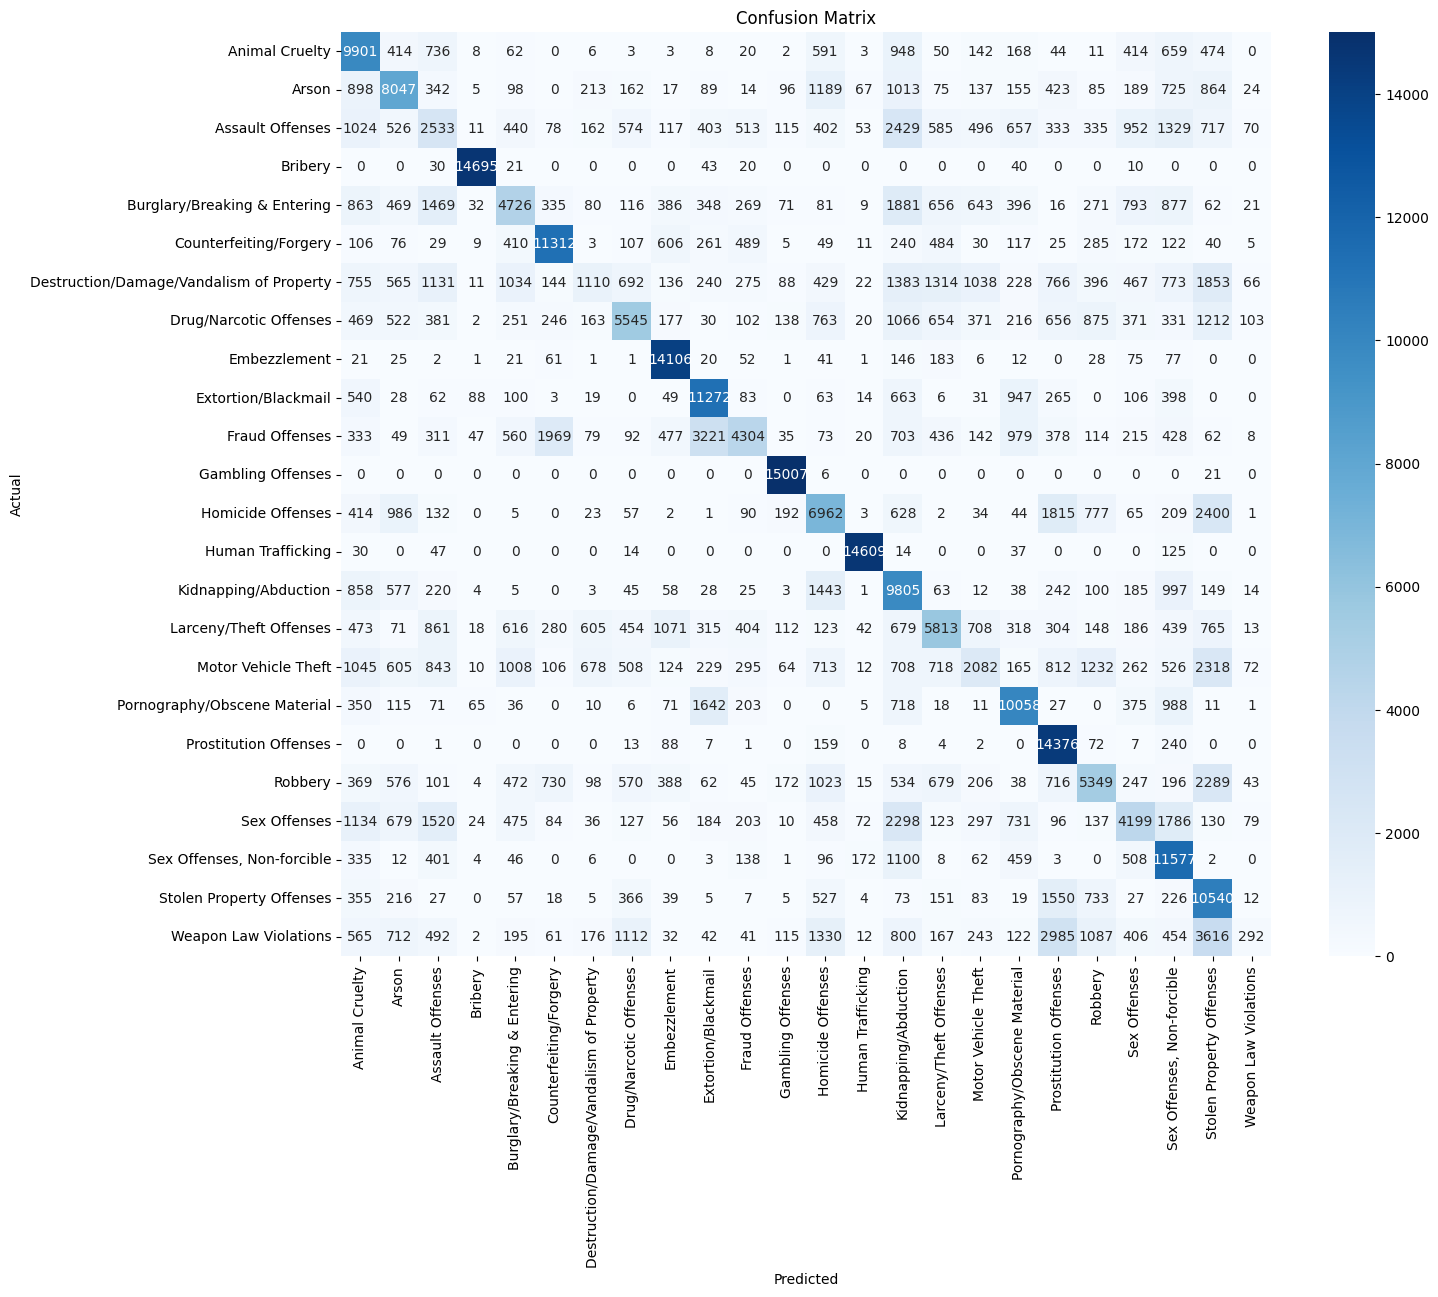

In [30]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
best_model = load_model('best_model.keras')

# Make predictions on the test set
y_pred_probs = best_model.predict([X_s_test, X_t_test, X_e_test])
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted',labelpad=20)
plt.ylabel('Actual', labelpad=20)
plt.title('DNN Confusion Matrix for Top 5 Predicted Crime Categories', labelpad=30)
plt.xticks(rotation=45, ha='right')
plt.show()